In [11]:
import os
import pandas as pd 
import numpy as np
import datetime as dt 
import math
import tensorflow as tf
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_poisson_deviance, mean_gamma_deviance, accuracy_score 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, GRU, Dropout, Dense,LSTM, Attention,Bidirectional,MultiHeadAttention,Attention, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow.keras
import matplotlib.pyplot as plt 
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as xp
import plotly.subplots as sp
tf.test.gpu_device_name()
import yfinance as yf
goog = yf.Ticker("GOOG")
goog_df = goog.history(period="max")
goog_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-08-19 00:00:00-04:00,2.490664,2.591785,2.390042,2.499133,897427216,0.0,0.0
2004-08-20 00:00:00-04:00,2.515820,2.716817,2.503118,2.697639,458857488,0.0,0.0
2004-08-23 00:00:00-04:00,2.758411,2.826406,2.716070,2.724787,366857939,0.0,0.0
2004-08-24 00:00:00-04:00,2.770615,2.779581,2.579581,2.611960,306396159,0.0,0.0
2004-08-25 00:00:00-04:00,2.614201,2.689918,2.587302,2.640104,184645512,0.0,0.0


In [12]:
goog_df.reset_index(inplace=True)

In [13]:
pred_open=goog_df[['Date','Open']]
pred_open

,Date,Open
0,2004-08-19 00:00:00-04:00,2.490664
1,2004-08-20 00:00:00-04:00,2.515820
2,2004-08-23 00:00:00-04:00,2.758411
3,2004-08-24 00:00:00-04:00,2.770615
4,2004-08-25 00:00:00-04:00,2.614201
...,...,...
4845,2023-11-16 00:00:00-05:00,136.960007
4846,2023-11-17 00:00:00-05:00,137.820007
4847,2023-11-20 00:00:00-05:00,135.500000
4848,2023-11-21 00:00:00-05:00,137.940002


In [14]:
goo=goog_df['Open']
goo

0         2.490664
1         2.515820
2         2.758411
3         2.770615
4         2.614201
           ...    
4845    136.960007
4846    137.820007
4847    135.500000
4848    137.940002
4849    139.100006
Name: Open, Length: 4850, dtype: float64

In [15]:

#Normalizing
scalar=MinMaxScaler(feature_range=(0,1))
goo=scalar.fit_transform(np.array(goo).reshape(-1,1))
goo.shape
#split train and test data
split_size_train_val=0.8
split_size_val_test=0.1
time_step=15
train,val,test=goo[0:int(len(goo)*split_size_train_val),:], goo[int(len(goo)*split_size_train_val):int(len(goo)*split_size_train_val)+int(len(goo)*split_size_val_test),:],goo[int(len(goo)*split_size_train_val)+int(len(goo)*split_size_val_test):,:]
print(train.shape,val.shape,test.shape)
#transform to time-series-like data


(3880, 1) (485, 1) (485, 1)


In [16]:
def time_series(goog_df,time_stemp):
    X=[]
    y=[]
    for i in range(len(goog_df)-time_step-1):
        a=goog_df[i:(i+time_stemp),0]
        X.append(a)
        y.append(goog_df[i+time_stemp])
    return np.array(X),np.array(y)
trainX,train_y=time_series(train,time_step)
valX,val_y=time_series(val,time_step)
testX,test_y=time_series(test,time_step)

print(trainX.shape,train_y.shape)
print(valX.shape,val_y.shape)
print(testX.shape,test_y.shape)

# reshape input to be [samples, time steps, features] which is required for LSTM
trainX =trainX.reshape(trainX.shape[0],trainX.shape[1] , 1)
valX = valX.reshape(valX.shape[0],valX.shape[1] , 1)
testX = testX.reshape(testX.shape[0],testX.shape[1] , 1)

print("X_train: ", trainX.shape)
print("X_Val: ", valX.shape)
print("X_test: ", testX.shape)

(3864, 15) (3864, 1)
(469, 15) (469, 1)
(469, 15) (469, 1)
X_train:  (3864, 15, 1)
X_Val:  (469, 15, 1)
X_test:  (469, 15, 1)


In [21]:
from attention import Attention
from keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
m = Sequential()
m.add(LSTM(64, return_sequences=True, input_shape=(time_step,1)))
m.add(Bidirectional(LSTM(64, return_sequences=True)))
m.add(Attention(32))
m.add(Dense(1))
m.compile(optimizer='adam', loss='mse')
m.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 15, 64)            16896     
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          66048     
 l)                                                              
                                                                 
 attention (Attention)       (None, 32)                24576     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 107,553
Trainable params: 107,553
Non-trainable params: 0
_________________________________________________________________


In [17]:
from attention import Attention
from keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
m = Sequential()
m.add(LSTM(64, return_sequences=True, input_shape=(time_step,1)))
#m.add(Dropout(0.4))
m.add(LSTM(32, return_sequences=True, input_shape=(time_step,1)))
#m.add(Dropout(0.4))
#m.add(Bidirectional(LSTM(64, return_sequences=True)))
#m.add(Attention(32))
m.add(Dense(1))
m.compile(optimizer='adam', loss='mse')
m.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 15, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 15, 32)            12416     
                                                                 
 dense_1 (Dense)             (None, 15, 1)             33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [22]:
callbacks = [tensorflow.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history=m.fit(trainX,train_y,
                  epochs=200,
                  validation_data=(valX,val_y),
                  verbose=1,
                  batch_size=32,
                  callbacks=callbacks
                 )

Epoch 1/200
121/121 [==============================] - 11s 35ms/step - loss: 8.4052e-04 - val_loss: 7.2775e-04
Epoch 2/200
121/121 [==============================] - 3s 24ms/step - loss: 4.2950e-05 - val_loss: 9.3059e-04
Epoch 3/200
121/121 [==============================] - 3s 24ms/step - loss: 4.3403e-05 - val_loss: 6.6831e-04
Epoch 4/200
121/121 [==============================] - 3s 28ms/step - loss: 4.4335e-05 - val_loss: 6.7237e-04
Epoch 5/200
121/121 [==============================] - 5s 42ms/step - loss: 4.1965e-05 - val_loss: 6.5745e-04
Epoch 6/200
121/121 [==============================] - 5s 39ms/step - loss: 4.0097e-05 - val_loss: 0.0010
Epoch 7/200
121/121 [==============================] - 5s 39ms/step - loss: 3.9612e-05 - val_loss: 4.9254e-04
Epoch 8/200
121/121 [==============================] - 6s 46ms/step - loss: 4.1514e-05 - val_loss: 7.5562e-04
Epoch 9/200
121/121 [==============================] - 5s 43ms/step - loss: 3.7759e-05 - val_loss: 5.4581e-04
Epoch 10/200


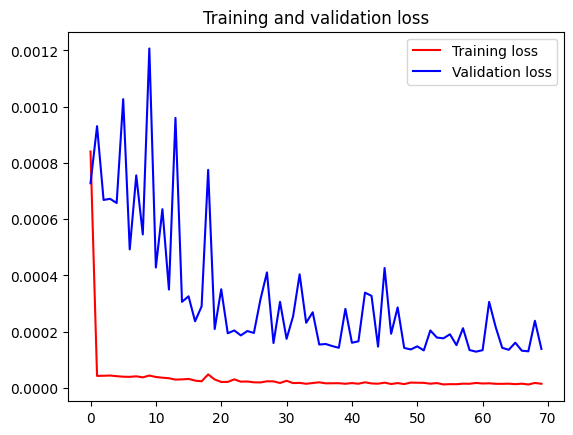

<Figure size 640x480 with 0 Axes>

In [23]:
#learning curves
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [24]:
train_predict=m.predict(trainX)
val_predict=m.predict(valX)
test_predict=m.predict(testX)
train_predict.shape, val_predict.shape, test_predict.shape

15/15 [==============================] - 0s 10ms/step


((3864, 1), (469, 1), (469, 1))